# Dimensionality reduction

I this notebook we will project multi-dimentional data into 2D/3D in a smart way.

The data we will be using is the [NMINST](http://yann.lecun.com/exdb/mnist/) dataset.

In [1]:
#import pandas, numpy and matplotlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # to do 3D plots scatter plots
import seaborn as sns                            # statistical data visualization toolkit (https://seaborn.pydata.org/)
import time                                      # track execution time of an algorithm
from sklearn.preprocessing import StandardScaler # mean

In this notebook we will use [Scikit Learn](https://scikit-learn.org/stable/) package. We will use this module for:
* Download the NMINST data
* Running the PCA and t-SNE algorithms

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
#Load the mnist data:
mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

We will convert the data to [pandas](https://pandas.pydata.org/) dataframe (df), so it will be easier later to make the plots

In [4]:
X, y = mnist

#X /= 255.0 # change to gray scale 
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None # clean the variables
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 786)


The dataset contains 70k digits, it will be too slow for us using all the data, hence, we will pick-up 5k random entries:

In [5]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
df = df.loc[rndperm[:5000]]
print('Reduced size of the dataframe is now: {}'.format(df.shape))

Reduced size of the dataframe is now: (5000, 786)


In [6]:
#see the what we have in the dataframe (note most of the entries are zeros)
df.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,y,label
46730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,8
48393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
41416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,8
34506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,7
43725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,7


Let's draw some digits:

<Figure size 432x288 with 0 Axes>

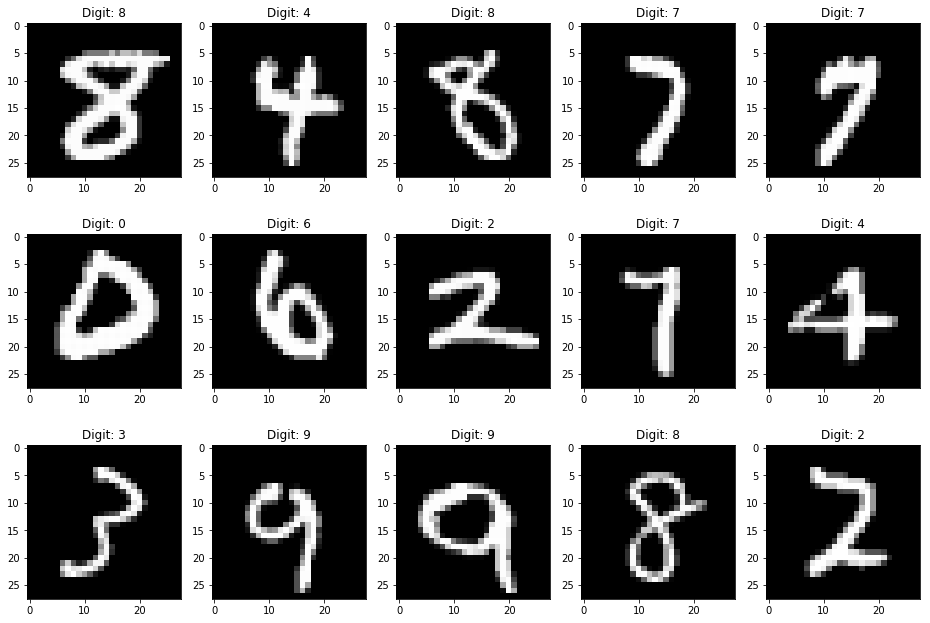

In [7]:
plt.gray()
fig = plt.figure( figsize=(16,11) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.imshow(df.iloc[i][feat_cols].values.reshape((28,28)).astype(float))
plt.show()

### PCA

We already experience with CNN, and we can easily run clasification task to distimguish between the digits. In the tutorial we discuss the PCA algorithm, let's see it implemented with the [Scikit-Learn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).
We will use 3 principle components (reduction from 784D to 3D)

In [8]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values) #dimensionality reduction in X
#add new axis to the dataframe
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Somthing retained: {:2.1f}%'.format(pca.explained_variance_ratio_.sum()*100))

Explained variation per principal component: [0.09611759 0.07086586 0.06169083]
Somthing retained: 22.9%


The sum of eigen values of first two principle components is ~10%. This is not large, but still let's try to see how PCA performes for 784D&rarr;2D. 

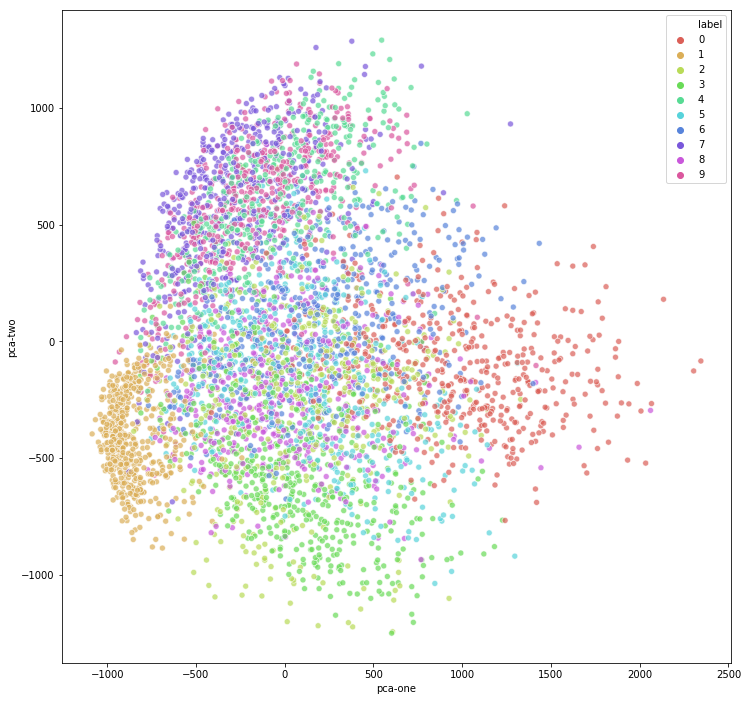

In [9]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)

As we see even when we retaining only 10% of the information, do a good work for some specific digits, like '1' or '0', but can we do better? Let's take a look on the 3D plot:

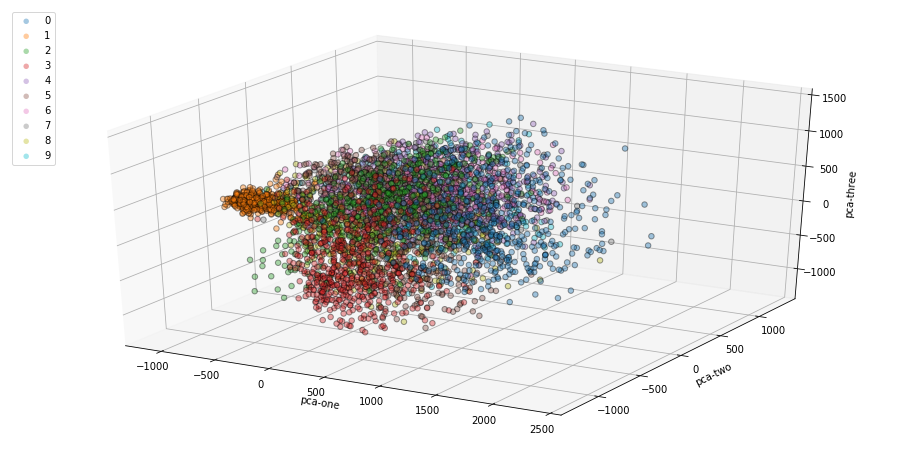

In [10]:
ax = plt.figure(figsize=(16,8)).gca(projection='3d')
for name, group in df.groupby('label'):
    ax.scatter(xs=group["pca-one"], ys=group["pca-two"], zs=group["pca-three"],
               alpha=0.4, cmap='tab10', edgecolors='none', s=30, label=name)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
ax.legend(loc=2); plt.show()

## t-SNE
t-Distributed Stochastic Neighbor Embedding ([t-SNE](http://lvdmaaten.github.io/tsne/)) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one.
Note: one of the limitation (as discussed in the tutorial) is it computationally heavy. In case of very high dimensional data, you may need to apply another dimensopnality reduction technique before using t-SNE.

In [11]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.423s...
[t-SNE] Computed neighbors for 5000 samples in 31.946s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 490.644761
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.347511
[t-SNE] KL divergence after 300 iterations: 2.152876
t-SNE done! Time elapsed: 53.233298778533936 seconds


Let's plots the results in 2D, note the differnce between the PCA and t-SNE, does it look better? 🙆😊

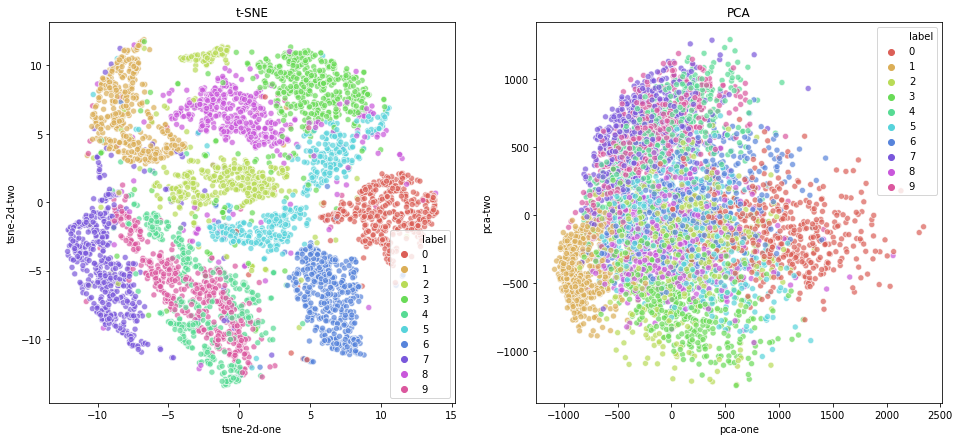

In [12]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE')
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('PCA')
plt.show()

Now let's follow the recommendations, reducing the dimentions with PCA and latter with t-SNE: 784D&rarr;(PCA)&rarr;50D&rarr;(t-SNE)&rarr;2D

In [13]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values) #dimensionality reduction in X
print('For 50 principal components retain {:2.1f}% of the information'.format(pca_50.explained_variance_ratio_.sum()*100))

For 50 principal components retain 82.7% of the information


In [14]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 2.449s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 386.701678
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.619110
[t-SNE] KL divergence after 300 iterations: 2.099722
t-SNE done! Time elapsed: 20.769153118133545 seconds


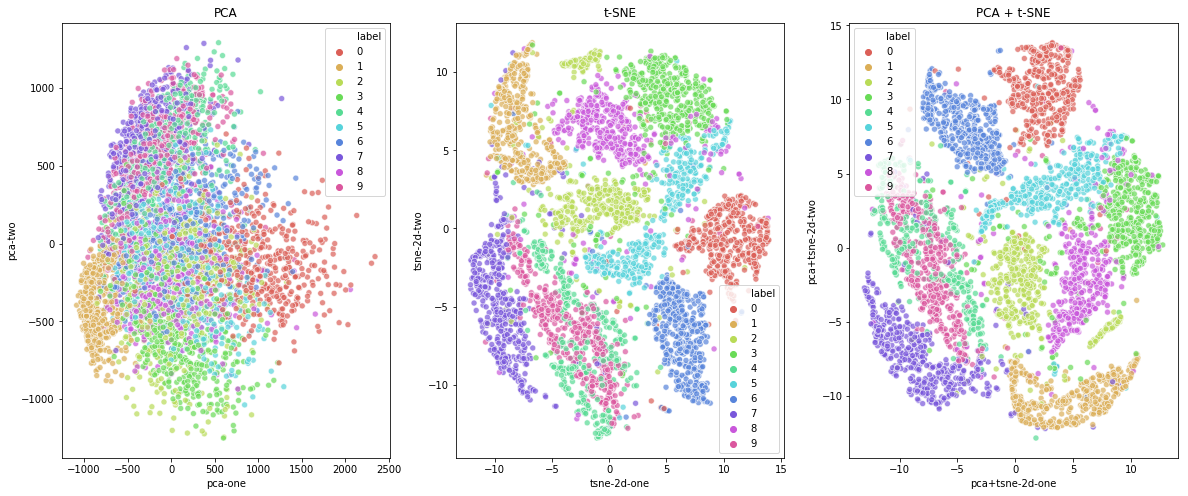

In [15]:
df['pca+tsne-2d-one'] = tsne_pca_results[:,0]
df['pca+tsne-2d-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(20,8))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('PCA')
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE')
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="pca+tsne-2d-one", y="pca+tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)
plt.title('PCA + t-SNE')
plt.show()